In [15]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle

# Device configuration
device = torch.device('cuda')

In [16]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=16)

In [17]:
vae = torch.load('vae16.pth')
vae.eval()
vae = vae.to(device)

In [18]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
train_set = train_dataset.data
# print(train_set)
# train_set = torch.reshape(train_set, (60000, 784))/1.0
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
# print(train_set)

p = []
for data, _ in train_loader:
    data = data.to(device)
    _, mu, var = vae(data)
    c = torch.cat((mu, var),dim = 1)
    p.append(c)
p  = torch.stack(list(p), dim=0)
p = torch.reshape(p,(60000, 1, 32, 1))
train_loader = torch.utils.data.DataLoader(dataset=p, batch_size=bs, shuffle=True)

In [19]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim, vae):
        super(Generator, self).__init__()
        self.vae = vae     
        self.fc1 = nn.Linear(g_input_dim, 128)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        # x = self.vae.decoder(x)

        return x
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim, vae):
        super(Discriminator, self).__init__()
        self.vae = vae
        self.fc1 = nn.Linear(d_input_dim, 32)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        # print(x.shape)
        mu, var = torch.split(x, 16, dim = 1)
        x = self.vae.sampling(mu, var)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [20]:
# build network
z_dim = 64
mnist_dim = 32

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim, vae=vae).to(device)
D = Discriminator(16, vae = vae).to(device)

In [21]:
G

Generator(
  (vae): VAE(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc31): Linear(in_features=256, out_features=16, bias=True)
    (fc32): Linear(in_features=256, out_features=16, bias=True)
    (fc4): Linear(in_features=16, out_features=256, bias=True)
    (fc5): Linear(in_features=256, out_features=512, bias=True)
    (fc6): Linear(in_features=512, out_features=784, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=32, bias=True)
)

In [22]:
D

Discriminator(
  (vae): VAE(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc31): Linear(in_features=256, out_features=16, bias=True)
    (fc32): Linear(in_features=256, out_features=16, bias=True)
    (fc4): Linear(in_features=16, out_features=256, bias=True)
    (fc5): Linear(in_features=256, out_features=512, bias=True)
    (fc6): Linear(in_features=512, out_features=784, bias=True)
  )
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)

In [23]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0005 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [24]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))
    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable((torch.randn(bs, z_dim)).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))
    # print(x_fake.shape)
    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [25]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable((torch.randn(bs, z_dim)).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

600it [00:05, 113.21it/s]


[1/500]: loss_d: 1.342, loss_g: 0.786


600it [00:04, 132.57it/s]


[2/500]: loss_d: 1.358, loss_g: 0.749


600it [00:04, 141.67it/s]


[3/500]: loss_d: 1.326, loss_g: 0.854


600it [00:22, 26.92it/s]


[4/500]: loss_d: 1.038, loss_g: 1.728


600it [00:22, 27.27it/s]


[5/500]: loss_d: 1.185, loss_g: 1.138


600it [00:21, 28.45it/s]


[6/500]: loss_d: 0.902, loss_g: 1.786


600it [00:19, 30.31it/s]


[7/500]: loss_d: 0.991, loss_g: 1.566


600it [00:20, 29.69it/s]


[8/500]: loss_d: 0.930, loss_g: 1.648


600it [00:24, 24.87it/s]


[9/500]: loss_d: 0.805, loss_g: 1.902


600it [00:23, 25.57it/s]


[10/500]: loss_d: 0.598, loss_g: 2.530


600it [00:20, 28.63it/s]


[11/500]: loss_d: 0.895, loss_g: 1.723


600it [00:25, 23.70it/s]


[12/500]: loss_d: 0.762, loss_g: 2.110


600it [00:20, 29.09it/s]


[13/500]: loss_d: 1.009, loss_g: 1.596


600it [00:21, 27.59it/s]


[14/500]: loss_d: 0.999, loss_g: 1.563


600it [00:22, 26.28it/s]


[15/500]: loss_d: 1.055, loss_g: 1.356


600it [00:22, 26.38it/s]


[16/500]: loss_d: 1.041, loss_g: 1.385


600it [00:21, 28.11it/s]


[17/500]: loss_d: 1.064, loss_g: 1.370


600it [00:20, 28.79it/s]


[18/500]: loss_d: 1.034, loss_g: 1.404


600it [00:18, 31.65it/s]


[19/500]: loss_d: 1.061, loss_g: 1.370


600it [00:24, 24.38it/s]


[20/500]: loss_d: 1.057, loss_g: 1.337


600it [00:22, 26.33it/s]


[21/500]: loss_d: 1.109, loss_g: 1.249


600it [00:21, 28.02it/s]


[22/500]: loss_d: 0.971, loss_g: 1.571


600it [00:27, 21.58it/s]


[23/500]: loss_d: 1.018, loss_g: 1.501


600it [00:04, 120.71it/s]


[24/500]: loss_d: 1.055, loss_g: 1.361


600it [00:04, 135.49it/s]


[25/500]: loss_d: 0.998, loss_g: 1.479


600it [00:16, 36.71it/s] 


[26/500]: loss_d: 0.957, loss_g: 1.650


600it [00:10, 59.42it/s] 


[27/500]: loss_d: 1.060, loss_g: 1.368


600it [00:04, 145.60it/s]


[28/500]: loss_d: 1.121, loss_g: 1.206


600it [00:04, 148.38it/s]


[29/500]: loss_d: 1.045, loss_g: 1.435


600it [00:04, 147.44it/s]


[30/500]: loss_d: 1.040, loss_g: 1.383


600it [00:04, 145.56it/s]


[31/500]: loss_d: 1.029, loss_g: 1.414


600it [00:04, 144.68it/s]


[32/500]: loss_d: 0.970, loss_g: 1.563


600it [00:04, 145.74it/s]


[33/500]: loss_d: 0.892, loss_g: 1.673


600it [00:04, 147.68it/s]


[34/500]: loss_d: 0.838, loss_g: 1.809


600it [00:04, 138.66it/s]


[35/500]: loss_d: 0.838, loss_g: 1.793


600it [00:08, 73.62it/s] 


[36/500]: loss_d: 0.868, loss_g: 1.714


600it [00:22, 26.51it/s]


[37/500]: loss_d: 0.880, loss_g: 1.691


600it [00:22, 26.87it/s]


[38/500]: loss_d: 0.938, loss_g: 1.535


600it [00:21, 27.82it/s]


[39/500]: loss_d: 1.085, loss_g: 1.281


600it [00:25, 23.45it/s]


[40/500]: loss_d: 0.963, loss_g: 1.638


600it [00:23, 25.27it/s]


[41/500]: loss_d: 0.887, loss_g: 1.825


600it [00:23, 25.51it/s]


[42/500]: loss_d: 0.772, loss_g: 2.072


600it [00:23, 25.98it/s]


[43/500]: loss_d: 0.872, loss_g: 1.735


600it [00:22, 26.51it/s]


[44/500]: loss_d: 1.071, loss_g: 1.320


600it [00:23, 25.11it/s]


[45/500]: loss_d: 0.885, loss_g: 1.788


600it [00:23, 26.06it/s]


[46/500]: loss_d: 0.938, loss_g: 1.697


600it [00:23, 25.45it/s]


[47/500]: loss_d: 1.006, loss_g: 1.477


600it [00:24, 24.99it/s]


[48/500]: loss_d: 0.957, loss_g: 1.604


600it [00:19, 30.56it/s] 


[49/500]: loss_d: 0.963, loss_g: 1.631


600it [00:04, 146.29it/s]


[50/500]: loss_d: 0.992, loss_g: 1.539


600it [00:04, 140.08it/s]


[51/500]: loss_d: 1.033, loss_g: 1.411


600it [00:04, 139.97it/s]


[52/500]: loss_d: 0.999, loss_g: 1.506


600it [00:04, 142.07it/s]


[53/500]: loss_d: 0.944, loss_g: 1.710


600it [00:04, 139.40it/s]


[54/500]: loss_d: 1.110, loss_g: 1.258


600it [00:04, 123.57it/s]


[55/500]: loss_d: 0.973, loss_g: 1.547


600it [00:04, 132.50it/s]


[56/500]: loss_d: 1.018, loss_g: 1.434


600it [00:05, 102.55it/s]


[57/500]: loss_d: 1.004, loss_g: 1.484


600it [00:05, 111.20it/s]


[58/500]: loss_d: 0.990, loss_g: 1.479


600it [00:04, 141.33it/s]


[59/500]: loss_d: 0.952, loss_g: 1.626


600it [00:04, 146.98it/s]


[60/500]: loss_d: 1.015, loss_g: 1.457


600it [00:04, 143.83it/s]


[61/500]: loss_d: 1.100, loss_g: 1.235


600it [00:04, 147.41it/s]


[62/500]: loss_d: 1.084, loss_g: 1.275


600it [00:04, 149.81it/s]


[63/500]: loss_d: 0.999, loss_g: 1.508


600it [00:04, 143.78it/s]


[64/500]: loss_d: 1.159, loss_g: 1.157


600it [00:04, 142.36it/s]


[65/500]: loss_d: 1.064, loss_g: 1.367


600it [00:04, 132.81it/s]


[66/500]: loss_d: 1.091, loss_g: 1.275


600it [00:04, 146.98it/s]


[67/500]: loss_d: 1.060, loss_g: 1.349


600it [00:04, 137.33it/s]


[68/500]: loss_d: 1.050, loss_g: 1.343


600it [00:04, 137.86it/s]


[69/500]: loss_d: 1.137, loss_g: 1.172


600it [00:04, 141.29it/s]


[70/500]: loss_d: 1.061, loss_g: 1.312


600it [00:04, 134.70it/s]


[71/500]: loss_d: 1.031, loss_g: 1.418


600it [00:16, 36.59it/s] 


[72/500]: loss_d: 1.080, loss_g: 1.302


600it [00:23, 25.36it/s]


[73/500]: loss_d: 1.111, loss_g: 1.220


600it [00:23, 25.08it/s]


[74/500]: loss_d: 1.157, loss_g: 1.137


600it [00:24, 24.25it/s]


[75/500]: loss_d: 1.149, loss_g: 1.142


600it [00:24, 24.78it/s]


[76/500]: loss_d: 1.070, loss_g: 1.329


600it [00:25, 23.61it/s]


[77/500]: loss_d: 1.065, loss_g: 1.360


600it [00:25, 23.64it/s]


[78/500]: loss_d: 1.088, loss_g: 1.291


600it [00:25, 23.86it/s]


[79/500]: loss_d: 1.070, loss_g: 1.333


600it [00:23, 25.84it/s]


[80/500]: loss_d: 1.139, loss_g: 1.180


600it [00:24, 24.94it/s]


[81/500]: loss_d: 1.197, loss_g: 1.043


600it [00:25, 23.41it/s]


[82/500]: loss_d: 1.146, loss_g: 1.162


600it [00:23, 25.22it/s]


[83/500]: loss_d: 1.151, loss_g: 1.142


600it [00:23, 25.82it/s]


[84/500]: loss_d: 1.121, loss_g: 1.238


600it [00:24, 24.97it/s]


[85/500]: loss_d: 1.124, loss_g: 1.213


600it [00:22, 26.16it/s]


[86/500]: loss_d: 1.117, loss_g: 1.247


600it [00:21, 27.65it/s]


[87/500]: loss_d: 1.124, loss_g: 1.224


600it [00:22, 26.87it/s]


[88/500]: loss_d: 1.076, loss_g: 1.308


600it [00:26, 22.90it/s]


[89/500]: loss_d: 1.097, loss_g: 1.260


600it [00:23, 25.35it/s]


[90/500]: loss_d: 1.069, loss_g: 1.325


600it [00:12, 46.18it/s] 


[91/500]: loss_d: 1.164, loss_g: 1.124


600it [00:04, 135.60it/s]


[92/500]: loss_d: 1.186, loss_g: 1.061


600it [00:04, 138.93it/s]


[93/500]: loss_d: 1.088, loss_g: 1.243


600it [00:04, 140.21it/s]


[94/500]: loss_d: 1.178, loss_g: 1.113


600it [00:04, 140.86it/s]


[95/500]: loss_d: 1.182, loss_g: 1.077


600it [00:04, 140.64it/s]


[96/500]: loss_d: 1.151, loss_g: 1.138


600it [00:04, 139.32it/s]


[97/500]: loss_d: 1.144, loss_g: 1.168


600it [00:04, 138.21it/s]


[98/500]: loss_d: 1.084, loss_g: 1.279


600it [00:04, 139.24it/s]


[99/500]: loss_d: 1.135, loss_g: 1.190


600it [00:04, 139.12it/s]


[100/500]: loss_d: 1.160, loss_g: 1.119


600it [00:04, 139.36it/s]


[101/500]: loss_d: 1.156, loss_g: 1.146


600it [00:04, 139.12it/s]


[102/500]: loss_d: 1.132, loss_g: 1.184


600it [00:04, 138.98it/s]


[103/500]: loss_d: 1.157, loss_g: 1.144


600it [00:04, 141.36it/s]


[104/500]: loss_d: 1.147, loss_g: 1.170


600it [00:04, 140.51it/s]


[105/500]: loss_d: 1.122, loss_g: 1.220


600it [00:04, 139.33it/s]


[106/500]: loss_d: 1.169, loss_g: 1.102


600it [00:04, 138.61it/s]


[107/500]: loss_d: 1.084, loss_g: 1.303


600it [00:04, 136.72it/s]


[108/500]: loss_d: 1.187, loss_g: 1.053


600it [00:04, 139.18it/s]


[109/500]: loss_d: 1.150, loss_g: 1.148


600it [00:04, 141.18it/s]


[110/500]: loss_d: 1.173, loss_g: 1.114


600it [00:04, 138.58it/s]


[111/500]: loss_d: 1.154, loss_g: 1.143


600it [00:04, 140.94it/s]


[112/500]: loss_d: 1.220, loss_g: 1.015


600it [00:04, 141.14it/s]


[113/500]: loss_d: 1.186, loss_g: 1.069


600it [00:04, 138.13it/s]


[114/500]: loss_d: 1.132, loss_g: 1.176


600it [00:04, 137.52it/s]


[115/500]: loss_d: 1.138, loss_g: 1.156


600it [00:04, 138.88it/s]


[116/500]: loss_d: 1.143, loss_g: 1.183


600it [00:04, 136.18it/s]


[117/500]: loss_d: 1.220, loss_g: 1.000


600it [00:04, 139.63it/s]


[118/500]: loss_d: 1.123, loss_g: 1.198


600it [00:04, 141.17it/s]


[119/500]: loss_d: 1.100, loss_g: 1.254


600it [00:04, 132.18it/s]


[120/500]: loss_d: 1.186, loss_g: 1.069


600it [00:04, 137.53it/s]


[121/500]: loss_d: 1.132, loss_g: 1.189


600it [00:04, 139.27it/s]


[122/500]: loss_d: 1.201, loss_g: 1.036


600it [00:04, 139.86it/s]


[123/500]: loss_d: 1.167, loss_g: 1.100


600it [00:04, 140.39it/s]


[124/500]: loss_d: 1.070, loss_g: 1.339


600it [00:04, 126.37it/s]


[125/500]: loss_d: 1.145, loss_g: 1.165


600it [00:04, 133.11it/s]


[126/500]: loss_d: 1.181, loss_g: 1.076


600it [00:04, 136.19it/s]


[127/500]: loss_d: 1.167, loss_g: 1.101


600it [00:04, 137.39it/s]


[128/500]: loss_d: 1.123, loss_g: 1.188


600it [00:04, 141.65it/s]


[129/500]: loss_d: 1.077, loss_g: 1.325


600it [00:04, 137.97it/s]


[130/500]: loss_d: 1.140, loss_g: 1.151


600it [00:05, 119.74it/s]


[131/500]: loss_d: 1.153, loss_g: 1.130


600it [00:04, 128.85it/s]


[132/500]: loss_d: 1.197, loss_g: 1.013


600it [00:05, 110.66it/s]


[133/500]: loss_d: 1.171, loss_g: 1.091


600it [00:04, 133.91it/s]


[134/500]: loss_d: 1.182, loss_g: 1.076


600it [00:04, 130.57it/s]


[135/500]: loss_d: 1.229, loss_g: 0.984


600it [00:04, 131.63it/s]


[136/500]: loss_d: 1.201, loss_g: 1.033


600it [00:04, 125.30it/s]


[137/500]: loss_d: 1.156, loss_g: 1.127


600it [00:04, 138.90it/s]


[138/500]: loss_d: 1.176, loss_g: 1.087


600it [00:04, 137.56it/s]


[139/500]: loss_d: 1.189, loss_g: 1.053


600it [00:04, 139.09it/s]


[140/500]: loss_d: 1.192, loss_g: 1.058


600it [00:04, 140.43it/s]


[141/500]: loss_d: 1.183, loss_g: 1.060


600it [00:04, 136.44it/s]


[142/500]: loss_d: 1.182, loss_g: 1.071


600it [00:04, 138.03it/s]


[143/500]: loss_d: 1.258, loss_g: 0.922


600it [00:04, 133.72it/s]


[144/500]: loss_d: 1.193, loss_g: 1.067


600it [00:04, 136.21it/s]


[145/500]: loss_d: 1.097, loss_g: 1.283


600it [00:04, 137.46it/s]


[146/500]: loss_d: 1.167, loss_g: 1.104


600it [00:04, 138.85it/s]


[147/500]: loss_d: 1.218, loss_g: 1.013


600it [00:04, 139.07it/s]


[148/500]: loss_d: 1.162, loss_g: 1.128


600it [00:04, 137.85it/s]


[149/500]: loss_d: 1.203, loss_g: 1.064


600it [00:04, 133.47it/s]


[150/500]: loss_d: 1.179, loss_g: 1.092


600it [00:04, 139.10it/s]


[151/500]: loss_d: 1.162, loss_g: 1.108


600it [00:04, 139.98it/s]


[152/500]: loss_d: 1.144, loss_g: 1.179


600it [00:04, 128.01it/s]


[153/500]: loss_d: 1.131, loss_g: 1.192


600it [00:04, 134.17it/s]


[154/500]: loss_d: 1.125, loss_g: 1.194


600it [00:04, 131.75it/s]


[155/500]: loss_d: 1.113, loss_g: 1.228


600it [00:04, 135.76it/s]


[156/500]: loss_d: 1.165, loss_g: 1.133


600it [00:04, 138.48it/s]


[157/500]: loss_d: 1.143, loss_g: 1.160


600it [00:04, 137.89it/s]


[158/500]: loss_d: 1.174, loss_g: 1.111


600it [00:04, 140.02it/s]


[159/500]: loss_d: 1.237, loss_g: 0.958


600it [00:04, 140.55it/s]


[160/500]: loss_d: 1.195, loss_g: 1.042


600it [00:04, 140.13it/s]


[161/500]: loss_d: 1.156, loss_g: 1.107


600it [00:04, 139.86it/s]


[162/500]: loss_d: 1.171, loss_g: 1.097


600it [00:04, 139.54it/s]


[163/500]: loss_d: 1.169, loss_g: 1.095


600it [00:04, 137.17it/s]


[164/500]: loss_d: 1.156, loss_g: 1.120


600it [00:04, 142.02it/s]


[165/500]: loss_d: 1.165, loss_g: 1.112


600it [00:04, 137.16it/s]


[166/500]: loss_d: 1.244, loss_g: 0.947


600it [00:04, 139.27it/s]


[167/500]: loss_d: 1.191, loss_g: 1.058


600it [00:04, 140.93it/s]


[168/500]: loss_d: 1.182, loss_g: 1.100


600it [00:04, 139.84it/s]


[169/500]: loss_d: 1.226, loss_g: 0.981


600it [00:04, 139.56it/s]


[170/500]: loss_d: 1.158, loss_g: 1.085


600it [00:04, 138.95it/s]


[171/500]: loss_d: 1.151, loss_g: 1.128


600it [00:04, 138.56it/s]


[172/500]: loss_d: 1.096, loss_g: 1.277


600it [00:04, 136.95it/s]


[173/500]: loss_d: 1.097, loss_g: 1.271


600it [00:04, 140.53it/s]


[174/500]: loss_d: 1.122, loss_g: 1.211


600it [00:04, 141.56it/s]


[175/500]: loss_d: 1.169, loss_g: 1.122


600it [00:04, 138.51it/s]


[176/500]: loss_d: 1.131, loss_g: 1.219


600it [00:04, 137.57it/s]


[177/500]: loss_d: 1.116, loss_g: 1.213


600it [00:04, 139.02it/s]


[178/500]: loss_d: 1.135, loss_g: 1.149


600it [00:04, 138.45it/s]


[179/500]: loss_d: 1.172, loss_g: 1.081


600it [00:04, 136.48it/s]


[180/500]: loss_d: 1.135, loss_g: 1.170


600it [00:04, 138.01it/s]


[181/500]: loss_d: 1.141, loss_g: 1.152


600it [00:04, 141.00it/s]


[182/500]: loss_d: 1.178, loss_g: 1.077


600it [00:04, 139.97it/s]


[183/500]: loss_d: 1.218, loss_g: 1.005


600it [00:04, 138.32it/s]


[184/500]: loss_d: 1.239, loss_g: 0.954


600it [00:04, 133.04it/s]


[185/500]: loss_d: 1.218, loss_g: 1.006


600it [00:05, 109.06it/s]


[186/500]: loss_d: 1.095, loss_g: 1.257


600it [00:04, 125.64it/s]


[187/500]: loss_d: 1.131, loss_g: 1.187


600it [00:05, 112.87it/s]


[188/500]: loss_d: 1.181, loss_g: 1.082


600it [00:05, 114.00it/s]


[189/500]: loss_d: 1.067, loss_g: 1.347


600it [00:05, 116.33it/s]


[190/500]: loss_d: 1.152, loss_g: 1.126


600it [00:04, 121.94it/s]


[191/500]: loss_d: 1.207, loss_g: 1.009


600it [00:04, 136.83it/s]


[192/500]: loss_d: 1.217, loss_g: 1.000


600it [00:04, 139.17it/s]


[193/500]: loss_d: 1.162, loss_g: 1.129


600it [00:04, 140.45it/s]


[194/500]: loss_d: 1.183, loss_g: 1.057


600it [00:04, 140.09it/s]


[195/500]: loss_d: 1.197, loss_g: 1.036


600it [00:04, 138.38it/s]


[196/500]: loss_d: 1.236, loss_g: 0.971


600it [00:04, 138.96it/s]


[197/500]: loss_d: 1.174, loss_g: 1.084


600it [00:04, 136.38it/s]


[198/500]: loss_d: 1.192, loss_g: 1.047


600it [00:04, 135.35it/s]


[199/500]: loss_d: 1.191, loss_g: 1.063


600it [00:04, 130.73it/s]


[200/500]: loss_d: 1.209, loss_g: 1.014


600it [00:04, 137.34it/s]


[201/500]: loss_d: 1.155, loss_g: 1.125


600it [00:04, 136.00it/s]


[202/500]: loss_d: 1.169, loss_g: 1.102


600it [00:04, 138.54it/s]


[203/500]: loss_d: 1.208, loss_g: 1.024


600it [00:04, 135.68it/s]


[204/500]: loss_d: 1.171, loss_g: 1.104


600it [00:04, 135.64it/s]


[205/500]: loss_d: 1.146, loss_g: 1.169


600it [00:04, 133.61it/s]


[206/500]: loss_d: 1.201, loss_g: 1.037


600it [00:04, 138.16it/s]


[207/500]: loss_d: 1.140, loss_g: 1.173


600it [00:04, 137.85it/s]


[208/500]: loss_d: 1.131, loss_g: 1.175


600it [00:04, 135.81it/s]


[209/500]: loss_d: 1.195, loss_g: 1.063


600it [00:04, 137.74it/s]


[210/500]: loss_d: 1.157, loss_g: 1.145


600it [00:04, 137.76it/s]


[211/500]: loss_d: 1.163, loss_g: 1.129


600it [00:04, 133.92it/s]


[212/500]: loss_d: 1.114, loss_g: 1.247


600it [00:04, 136.48it/s]


[213/500]: loss_d: 1.150, loss_g: 1.141


600it [00:04, 140.72it/s]


[214/500]: loss_d: 1.139, loss_g: 1.180


600it [00:04, 137.13it/s]


[215/500]: loss_d: 1.123, loss_g: 1.201


600it [00:04, 139.90it/s]


[216/500]: loss_d: 1.124, loss_g: 1.208


600it [00:04, 140.25it/s]


[217/500]: loss_d: 1.210, loss_g: 1.021


600it [00:04, 137.85it/s]


[218/500]: loss_d: 1.182, loss_g: 1.069


600it [00:04, 138.77it/s]


[219/500]: loss_d: 1.174, loss_g: 1.087


600it [00:04, 137.84it/s]


[220/500]: loss_d: 1.167, loss_g: 1.118


600it [00:04, 124.88it/s]


[221/500]: loss_d: 1.160, loss_g: 1.131


600it [00:04, 139.95it/s]


[222/500]: loss_d: 1.238, loss_g: 0.965


600it [00:04, 139.68it/s]


[223/500]: loss_d: 1.196, loss_g: 1.046


600it [00:04, 139.54it/s]


[224/500]: loss_d: 1.157, loss_g: 1.127


600it [00:04, 136.28it/s]


[225/500]: loss_d: 1.213, loss_g: 1.020


600it [00:04, 138.15it/s]


[226/500]: loss_d: 1.157, loss_g: 1.143


600it [00:04, 135.31it/s]


[227/500]: loss_d: 1.127, loss_g: 1.211


600it [00:04, 135.96it/s]


[228/500]: loss_d: 1.120, loss_g: 1.199


600it [00:04, 137.94it/s]


[229/500]: loss_d: 1.162, loss_g: 1.115


600it [00:04, 139.09it/s]


[230/500]: loss_d: 1.129, loss_g: 1.195


600it [00:04, 140.05it/s]


[231/500]: loss_d: 1.140, loss_g: 1.178


600it [00:04, 140.55it/s]


[232/500]: loss_d: 1.194, loss_g: 1.055


600it [00:04, 137.00it/s]


[233/500]: loss_d: 1.196, loss_g: 1.041


600it [00:04, 139.31it/s]


[234/500]: loss_d: 1.186, loss_g: 1.066


600it [00:04, 137.11it/s]


[235/500]: loss_d: 1.207, loss_g: 1.024


600it [00:04, 137.99it/s]


[236/500]: loss_d: 1.154, loss_g: 1.133


600it [00:04, 136.83it/s]


[237/500]: loss_d: 1.163, loss_g: 1.126


600it [00:04, 136.71it/s]


[238/500]: loss_d: 1.146, loss_g: 1.168


600it [00:04, 123.42it/s]


[239/500]: loss_d: 1.182, loss_g: 1.081


600it [00:04, 124.35it/s]


[240/500]: loss_d: 1.169, loss_g: 1.104


600it [00:04, 135.01it/s]


[241/500]: loss_d: 1.134, loss_g: 1.164


600it [00:04, 125.35it/s]


[242/500]: loss_d: 1.162, loss_g: 1.123


600it [00:04, 127.67it/s]


[243/500]: loss_d: 1.121, loss_g: 1.202


600it [00:04, 124.68it/s]


[244/500]: loss_d: 1.163, loss_g: 1.119


600it [00:04, 132.08it/s]


[245/500]: loss_d: 1.163, loss_g: 1.131


600it [00:04, 140.46it/s]


[246/500]: loss_d: 1.171, loss_g: 1.093


600it [00:04, 136.22it/s]


[247/500]: loss_d: 1.172, loss_g: 1.091


600it [00:04, 138.48it/s]


[248/500]: loss_d: 1.198, loss_g: 1.041


600it [00:04, 139.89it/s]


[249/500]: loss_d: 1.203, loss_g: 1.024


600it [00:04, 141.67it/s]


[250/500]: loss_d: 1.181, loss_g: 1.072


600it [00:04, 143.25it/s]


[251/500]: loss_d: 1.165, loss_g: 1.108


600it [00:04, 142.39it/s]


[252/500]: loss_d: 1.177, loss_g: 1.080


600it [00:04, 124.06it/s]


[253/500]: loss_d: 1.183, loss_g: 1.063


600it [00:05, 116.11it/s]


[254/500]: loss_d: 1.129, loss_g: 1.205


600it [00:05, 113.99it/s]


[255/500]: loss_d: 1.139, loss_g: 1.141


600it [00:04, 129.21it/s]


[256/500]: loss_d: 1.164, loss_g: 1.094


600it [00:05, 113.67it/s]


[257/500]: loss_d: 1.198, loss_g: 1.040


600it [00:05, 114.19it/s]


[258/500]: loss_d: 1.148, loss_g: 1.136


600it [00:05, 116.56it/s]


[259/500]: loss_d: 1.176, loss_g: 1.092


600it [00:04, 136.39it/s]


[260/500]: loss_d: 1.122, loss_g: 1.224


600it [00:04, 139.27it/s]


[261/500]: loss_d: 1.127, loss_g: 1.207


600it [00:04, 138.12it/s]


[262/500]: loss_d: 1.146, loss_g: 1.166


600it [00:04, 139.76it/s]


[263/500]: loss_d: 1.151, loss_g: 1.134


600it [00:04, 135.59it/s]


[264/500]: loss_d: 1.241, loss_g: 0.948


600it [00:04, 137.76it/s]


[265/500]: loss_d: 1.189, loss_g: 1.055


600it [00:04, 135.94it/s]


[266/500]: loss_d: 1.133, loss_g: 1.186


600it [00:04, 137.97it/s]


[267/500]: loss_d: 1.176, loss_g: 1.091


600it [00:04, 138.19it/s]


[268/500]: loss_d: 1.192, loss_g: 1.057


600it [00:04, 138.01it/s]


[269/500]: loss_d: 1.170, loss_g: 1.091


600it [00:04, 136.89it/s]


[270/500]: loss_d: 1.168, loss_g: 1.110


600it [00:04, 137.89it/s]


[271/500]: loss_d: 1.172, loss_g: 1.098


600it [00:04, 140.75it/s]


[272/500]: loss_d: 1.114, loss_g: 1.231


600it [00:04, 134.50it/s]


[273/500]: loss_d: 1.173, loss_g: 1.099


600it [00:04, 137.19it/s]


[274/500]: loss_d: 1.208, loss_g: 1.020


600it [00:04, 137.75it/s]


[275/500]: loss_d: 1.222, loss_g: 0.994


600it [00:04, 141.06it/s]


[276/500]: loss_d: 1.222, loss_g: 0.995


600it [00:04, 138.29it/s]


[277/500]: loss_d: 1.172, loss_g: 1.106


600it [00:04, 139.88it/s]


[278/500]: loss_d: 1.197, loss_g: 1.036


600it [00:04, 136.18it/s]


[279/500]: loss_d: 1.218, loss_g: 0.997


600it [00:04, 139.28it/s]


[280/500]: loss_d: 1.224, loss_g: 1.000


600it [00:04, 141.34it/s]


[281/500]: loss_d: 1.148, loss_g: 1.144


600it [00:04, 138.95it/s]


[282/500]: loss_d: 1.118, loss_g: 1.206


600it [00:04, 139.82it/s]


[283/500]: loss_d: 1.220, loss_g: 1.003


600it [00:04, 139.39it/s]


[284/500]: loss_d: 1.212, loss_g: 1.029


600it [00:04, 139.80it/s]


[285/500]: loss_d: 1.107, loss_g: 1.262


600it [00:04, 140.40it/s]


[286/500]: loss_d: 1.112, loss_g: 1.254


600it [00:04, 120.99it/s]


[287/500]: loss_d: 1.159, loss_g: 1.145


600it [00:05, 101.39it/s]


[288/500]: loss_d: 1.193, loss_g: 1.051


600it [00:05, 103.13it/s]


[289/500]: loss_d: 1.174, loss_g: 1.083


600it [00:05, 106.98it/s]


[290/500]: loss_d: 1.116, loss_g: 1.193


600it [00:04, 139.37it/s]


[291/500]: loss_d: 1.065, loss_g: 1.324


600it [00:05, 112.59it/s]


[292/500]: loss_d: 1.118, loss_g: 1.218


600it [00:05, 102.64it/s]


[293/500]: loss_d: 1.142, loss_g: 1.154


600it [00:05, 106.63it/s]


[294/500]: loss_d: 1.203, loss_g: 1.012


600it [00:05, 100.75it/s]


[295/500]: loss_d: 1.213, loss_g: 0.998


600it [00:05, 104.86it/s]


[296/500]: loss_d: 1.175, loss_g: 1.083


600it [00:04, 129.40it/s]


[297/500]: loss_d: 1.167, loss_g: 1.118


600it [00:04, 144.10it/s]


[298/500]: loss_d: 1.123, loss_g: 1.205


600it [00:04, 141.93it/s]


[299/500]: loss_d: 1.064, loss_g: 1.344


600it [00:04, 145.03it/s]


[300/500]: loss_d: 1.109, loss_g: 1.241


600it [00:04, 144.74it/s]


[301/500]: loss_d: 1.224, loss_g: 0.986


600it [00:04, 139.61it/s]


[302/500]: loss_d: 1.190, loss_g: 1.070


600it [00:04, 141.78it/s]


[303/500]: loss_d: 1.127, loss_g: 1.215


600it [00:04, 120.33it/s]


[304/500]: loss_d: 1.145, loss_g: 1.172


600it [00:04, 125.69it/s]


[305/500]: loss_d: 1.163, loss_g: 1.120


600it [00:04, 138.83it/s]


[306/500]: loss_d: 1.195, loss_g: 1.054


600it [00:04, 135.86it/s]


[307/500]: loss_d: 1.156, loss_g: 1.140


600it [00:05, 114.28it/s]


[308/500]: loss_d: 1.173, loss_g: 1.097


600it [00:04, 128.72it/s]


[309/500]: loss_d: 1.198, loss_g: 1.041


600it [00:05, 113.11it/s]


[310/500]: loss_d: 1.172, loss_g: 1.099


600it [00:05, 113.14it/s]


[311/500]: loss_d: 1.179, loss_g: 1.090


600it [00:04, 136.59it/s]


[312/500]: loss_d: 1.180, loss_g: 1.087


600it [00:04, 138.07it/s]


[313/500]: loss_d: 1.173, loss_g: 1.106


600it [00:04, 138.09it/s]


[314/500]: loss_d: 1.205, loss_g: 1.032


600it [00:04, 139.81it/s]


[315/500]: loss_d: 1.195, loss_g: 1.035


600it [00:04, 138.23it/s]


[316/500]: loss_d: 1.172, loss_g: 1.089


600it [00:04, 135.31it/s]


[317/500]: loss_d: 1.181, loss_g: 1.073


600it [00:04, 142.36it/s]


[318/500]: loss_d: 1.170, loss_g: 1.107


600it [00:04, 141.90it/s]


[319/500]: loss_d: 1.111, loss_g: 1.242


600it [00:04, 137.87it/s]


[320/500]: loss_d: 1.120, loss_g: 1.245


600it [00:04, 139.78it/s]


[321/500]: loss_d: 1.128, loss_g: 1.232


600it [00:04, 141.54it/s]


[322/500]: loss_d: 1.096, loss_g: 1.287


600it [00:04, 141.93it/s]


[323/500]: loss_d: 1.088, loss_g: 1.281


600it [00:04, 133.03it/s]


[324/500]: loss_d: 1.078, loss_g: 1.316


600it [00:04, 133.24it/s]


[325/500]: loss_d: 1.100, loss_g: 1.258


600it [00:04, 139.62it/s]


[326/500]: loss_d: 1.162, loss_g: 1.132


600it [00:04, 141.77it/s]


[327/500]: loss_d: 1.208, loss_g: 1.017


600it [00:04, 143.72it/s]


[328/500]: loss_d: 1.240, loss_g: 0.956


600it [00:04, 141.48it/s]


[329/500]: loss_d: 1.206, loss_g: 1.030


600it [00:04, 138.83it/s]


[330/500]: loss_d: 1.225, loss_g: 0.995


600it [00:04, 137.73it/s]


[331/500]: loss_d: 1.186, loss_g: 1.063


600it [00:04, 143.17it/s]


[332/500]: loss_d: 1.158, loss_g: 1.138


600it [00:04, 142.59it/s]


[333/500]: loss_d: 1.164, loss_g: 1.116


600it [00:04, 141.73it/s]


[334/500]: loss_d: 1.182, loss_g: 1.068


600it [00:04, 143.40it/s]


[335/500]: loss_d: 1.172, loss_g: 1.089


600it [00:04, 143.61it/s]


[336/500]: loss_d: 1.179, loss_g: 1.084


600it [00:04, 140.87it/s]


[337/500]: loss_d: 1.199, loss_g: 1.034


600it [00:04, 137.57it/s]


[338/500]: loss_d: 1.169, loss_g: 1.108


600it [00:04, 137.61it/s]


[339/500]: loss_d: 1.140, loss_g: 1.170


600it [00:04, 138.80it/s]


[340/500]: loss_d: 1.163, loss_g: 1.126


600it [00:04, 137.98it/s]


[341/500]: loss_d: 1.135, loss_g: 1.199


600it [00:04, 138.62it/s]


[342/500]: loss_d: 1.095, loss_g: 1.287


600it [00:04, 138.38it/s]


[343/500]: loss_d: 1.121, loss_g: 1.237


600it [00:04, 140.91it/s]


[344/500]: loss_d: 1.158, loss_g: 1.140


600it [00:05, 110.87it/s]


[345/500]: loss_d: 1.175, loss_g: 1.108


600it [00:05, 105.53it/s]


[346/500]: loss_d: 1.175, loss_g: 1.102


600it [00:05, 100.95it/s]


[347/500]: loss_d: 1.179, loss_g: 1.087


600it [00:05, 107.28it/s]


[348/500]: loss_d: 1.189, loss_g: 1.074


600it [00:05, 103.94it/s]


[349/500]: loss_d: 1.182, loss_g: 1.056


600it [00:04, 121.13it/s]


[350/500]: loss_d: 1.127, loss_g: 1.188


600it [00:04, 143.96it/s]


[351/500]: loss_d: 1.117, loss_g: 1.220


600it [00:04, 144.39it/s]


[352/500]: loss_d: 1.129, loss_g: 1.201


600it [00:04, 142.36it/s]


[353/500]: loss_d: 1.188, loss_g: 1.072


600it [00:04, 140.31it/s]


[354/500]: loss_d: 1.224, loss_g: 0.985


600it [00:04, 129.39it/s]


[355/500]: loss_d: 1.190, loss_g: 1.062


600it [00:04, 138.67it/s]


[356/500]: loss_d: 1.197, loss_g: 1.049


600it [00:04, 123.44it/s]


[357/500]: loss_d: 1.204, loss_g: 1.026


600it [00:05, 112.17it/s]


[358/500]: loss_d: 1.097, loss_g: 1.278


600it [00:04, 124.70it/s]


[359/500]: loss_d: 1.131, loss_g: 1.196


600it [00:04, 125.99it/s]


[360/500]: loss_d: 1.153, loss_g: 1.158


600it [00:04, 126.29it/s]


[361/500]: loss_d: 1.135, loss_g: 1.184


600it [00:04, 122.50it/s]


[362/500]: loss_d: 1.138, loss_g: 1.198


600it [00:04, 128.05it/s]


[363/500]: loss_d: 1.151, loss_g: 1.160


600it [00:04, 138.95it/s]


[364/500]: loss_d: 1.161, loss_g: 1.140


600it [00:04, 138.73it/s]


[365/500]: loss_d: 1.197, loss_g: 1.046


600it [00:04, 139.63it/s]


[366/500]: loss_d: 1.179, loss_g: 1.094


600it [00:04, 137.74it/s]


[367/500]: loss_d: 1.136, loss_g: 1.193


600it [00:04, 140.28it/s]


[368/500]: loss_d: 1.136, loss_g: 1.187


600it [00:04, 140.99it/s]


[369/500]: loss_d: 1.147, loss_g: 1.156


600it [00:04, 137.87it/s]


[370/500]: loss_d: 1.158, loss_g: 1.127


600it [00:04, 140.03it/s]


[371/500]: loss_d: 1.176, loss_g: 1.094


600it [00:04, 139.03it/s]


[372/500]: loss_d: 1.169, loss_g: 1.092


600it [00:04, 138.51it/s]


[373/500]: loss_d: 1.195, loss_g: 1.041


600it [00:04, 140.20it/s]


[374/500]: loss_d: 1.182, loss_g: 1.092


600it [00:04, 141.94it/s]


[375/500]: loss_d: 1.147, loss_g: 1.152


600it [00:04, 139.34it/s]


[376/500]: loss_d: 1.122, loss_g: 1.202


600it [00:04, 141.43it/s]


[377/500]: loss_d: 1.159, loss_g: 1.128


600it [00:04, 140.33it/s]


[378/500]: loss_d: 1.188, loss_g: 1.073


600it [00:04, 140.63it/s]


[379/500]: loss_d: 1.163, loss_g: 1.143


600it [00:04, 141.02it/s]


[380/500]: loss_d: 1.147, loss_g: 1.173


600it [00:04, 138.00it/s]


[381/500]: loss_d: 1.138, loss_g: 1.180


600it [00:04, 140.91it/s]


[382/500]: loss_d: 1.157, loss_g: 1.135


600it [00:04, 139.94it/s]


[383/500]: loss_d: 1.164, loss_g: 1.115


600it [00:04, 138.19it/s]


[384/500]: loss_d: 1.174, loss_g: 1.104


600it [00:04, 139.26it/s]


[385/500]: loss_d: 1.174, loss_g: 1.072


600it [00:04, 138.89it/s]


[386/500]: loss_d: 1.156, loss_g: 1.129


600it [00:04, 138.80it/s]


[387/500]: loss_d: 1.156, loss_g: 1.134


600it [00:04, 141.26it/s]


[388/500]: loss_d: 1.119, loss_g: 1.214


600it [00:04, 141.51it/s]


[389/500]: loss_d: 1.110, loss_g: 1.242


600it [00:04, 141.66it/s]


[390/500]: loss_d: 1.141, loss_g: 1.179


600it [00:04, 137.40it/s]


[391/500]: loss_d: 1.176, loss_g: 1.084


600it [00:04, 138.59it/s]


[392/500]: loss_d: 1.153, loss_g: 1.128


600it [00:04, 138.88it/s]


[393/500]: loss_d: 1.140, loss_g: 1.175


600it [00:04, 139.27it/s]


[394/500]: loss_d: 1.125, loss_g: 1.194


600it [00:04, 138.81it/s]


[395/500]: loss_d: 1.132, loss_g: 1.180


600it [00:04, 139.73it/s]


[396/500]: loss_d: 1.164, loss_g: 1.112


600it [00:04, 136.77it/s]


[397/500]: loss_d: 1.158, loss_g: 1.127


600it [00:05, 112.87it/s]


[398/500]: loss_d: 1.125, loss_g: 1.200


600it [00:05, 103.58it/s]


[399/500]: loss_d: 1.152, loss_g: 1.141


600it [00:05, 108.77it/s]


[400/500]: loss_d: 1.185, loss_g: 1.062


600it [00:05, 110.22it/s]


[401/500]: loss_d: 1.188, loss_g: 1.062


600it [00:05, 103.43it/s]


[402/500]: loss_d: 1.195, loss_g: 1.054


600it [00:05, 112.91it/s]


[403/500]: loss_d: 1.216, loss_g: 1.004


600it [00:04, 142.28it/s]


[404/500]: loss_d: 1.182, loss_g: 1.071


600it [00:04, 140.13it/s]


[405/500]: loss_d: 1.118, loss_g: 1.241


600it [00:04, 140.98it/s]


[406/500]: loss_d: 1.152, loss_g: 1.145


600it [00:04, 140.59it/s]


[407/500]: loss_d: 1.153, loss_g: 1.144


600it [00:04, 141.60it/s]


[408/500]: loss_d: 1.130, loss_g: 1.191


600it [00:04, 141.89it/s]


[409/500]: loss_d: 1.146, loss_g: 1.157


600it [00:04, 127.78it/s]


[410/500]: loss_d: 1.182, loss_g: 1.087


600it [00:05, 112.13it/s]


[411/500]: loss_d: 1.212, loss_g: 1.027


600it [00:04, 139.32it/s]


[412/500]: loss_d: 1.180, loss_g: 1.084


600it [00:04, 128.21it/s]


[413/500]: loss_d: 1.161, loss_g: 1.124


600it [00:04, 122.15it/s]


[414/500]: loss_d: 1.159, loss_g: 1.136


600it [00:05, 114.38it/s]


[415/500]: loss_d: 1.165, loss_g: 1.102


600it [00:04, 125.41it/s]


[416/500]: loss_d: 1.158, loss_g: 1.116


600it [00:04, 139.13it/s]


[417/500]: loss_d: 1.142, loss_g: 1.165


600it [00:04, 139.81it/s]


[418/500]: loss_d: 1.162, loss_g: 1.118


600it [00:04, 139.74it/s]


[419/500]: loss_d: 1.187, loss_g: 1.064


600it [00:04, 137.46it/s]


[420/500]: loss_d: 1.172, loss_g: 1.097


600it [00:04, 138.38it/s]


[421/500]: loss_d: 1.173, loss_g: 1.098


600it [00:04, 139.57it/s]


[422/500]: loss_d: 1.163, loss_g: 1.119


600it [00:04, 134.19it/s]


[423/500]: loss_d: 1.159, loss_g: 1.136


600it [00:04, 137.14it/s]


[424/500]: loss_d: 1.120, loss_g: 1.224


600it [00:04, 140.13it/s]


[425/500]: loss_d: 1.105, loss_g: 1.249


600it [00:04, 138.33it/s]


[426/500]: loss_d: 1.142, loss_g: 1.180


600it [00:04, 140.37it/s]


[427/500]: loss_d: 1.153, loss_g: 1.142


600it [00:04, 136.83it/s]


[428/500]: loss_d: 1.124, loss_g: 1.212


600it [00:04, 133.97it/s]


[429/500]: loss_d: 1.146, loss_g: 1.162


600it [00:04, 141.45it/s]


[430/500]: loss_d: 1.157, loss_g: 1.142


600it [00:04, 141.88it/s]


[431/500]: loss_d: 1.188, loss_g: 1.070


600it [00:04, 138.79it/s]


[432/500]: loss_d: 1.197, loss_g: 1.045


600it [00:04, 141.87it/s]


[433/500]: loss_d: 1.192, loss_g: 1.058


600it [00:04, 139.74it/s]


[434/500]: loss_d: 1.199, loss_g: 1.057


600it [00:04, 141.73it/s]


[435/500]: loss_d: 1.179, loss_g: 1.089


600it [00:04, 140.94it/s]


[436/500]: loss_d: 1.157, loss_g: 1.143


600it [00:04, 137.74it/s]


[437/500]: loss_d: 1.123, loss_g: 1.210


600it [00:04, 140.56it/s]


[438/500]: loss_d: 1.152, loss_g: 1.144


600it [00:04, 140.81it/s]


[439/500]: loss_d: 1.172, loss_g: 1.087


600it [00:04, 140.88it/s]


[440/500]: loss_d: 1.188, loss_g: 1.060


600it [00:04, 137.32it/s]


[441/500]: loss_d: 1.177, loss_g: 1.077


600it [00:04, 137.44it/s]


[442/500]: loss_d: 1.175, loss_g: 1.088


600it [00:04, 140.27it/s]


[443/500]: loss_d: 1.191, loss_g: 1.062


600it [00:04, 138.51it/s]


[444/500]: loss_d: 1.155, loss_g: 1.138


600it [00:04, 138.83it/s]


[445/500]: loss_d: 1.140, loss_g: 1.198


600it [00:04, 137.14it/s]


[446/500]: loss_d: 1.171, loss_g: 1.117


600it [00:04, 139.21it/s]


[447/500]: loss_d: 1.175, loss_g: 1.090


600it [00:04, 137.90it/s]


[448/500]: loss_d: 1.155, loss_g: 1.128


600it [00:04, 138.53it/s]


[449/500]: loss_d: 1.158, loss_g: 1.117


600it [00:04, 138.20it/s]


[450/500]: loss_d: 1.158, loss_g: 1.135


600it [00:04, 122.65it/s]


[451/500]: loss_d: 1.172, loss_g: 1.107


600it [00:05, 105.63it/s]


[452/500]: loss_d: 1.217, loss_g: 1.010


600it [00:05, 104.96it/s]


[453/500]: loss_d: 1.189, loss_g: 1.060


600it [00:05, 103.84it/s]


[454/500]: loss_d: 1.182, loss_g: 1.073


600it [00:05, 105.18it/s]


[455/500]: loss_d: 1.138, loss_g: 1.181


600it [00:05, 114.29it/s]


[456/500]: loss_d: 1.142, loss_g: 1.165


600it [00:04, 144.81it/s]


[457/500]: loss_d: 1.146, loss_g: 1.154


600it [00:04, 146.69it/s]


[458/500]: loss_d: 1.161, loss_g: 1.121


600it [00:04, 145.94it/s]


[459/500]: loss_d: 1.139, loss_g: 1.167


600it [00:04, 145.66it/s]


[460/500]: loss_d: 1.125, loss_g: 1.198


600it [00:04, 145.16it/s]


[461/500]: loss_d: 1.130, loss_g: 1.212


600it [00:04, 145.11it/s]


[462/500]: loss_d: 1.165, loss_g: 1.133


600it [00:04, 143.95it/s]


[463/500]: loss_d: 1.161, loss_g: 1.129


600it [00:05, 107.53it/s]


[464/500]: loss_d: 1.143, loss_g: 1.186


600it [00:05, 109.39it/s]


[465/500]: loss_d: 1.144, loss_g: 1.187


600it [00:04, 135.06it/s]


[466/500]: loss_d: 1.165, loss_g: 1.125


600it [00:04, 137.58it/s]


[467/500]: loss_d: 1.137, loss_g: 1.198


600it [00:05, 118.70it/s]


[468/500]: loss_d: 1.135, loss_g: 1.197


600it [00:04, 121.77it/s]


[469/500]: loss_d: 1.160, loss_g: 1.130


600it [00:05, 106.68it/s]


[470/500]: loss_d: 1.180, loss_g: 1.089


600it [00:04, 135.00it/s]


[471/500]: loss_d: 1.198, loss_g: 1.036


600it [00:04, 138.10it/s]


[472/500]: loss_d: 1.200, loss_g: 1.033


600it [00:04, 139.00it/s]


[473/500]: loss_d: 1.161, loss_g: 1.118


600it [00:04, 139.38it/s]


[474/500]: loss_d: 1.131, loss_g: 1.208


600it [00:04, 138.57it/s]


[475/500]: loss_d: 1.147, loss_g: 1.144


600it [00:04, 137.67it/s]


[476/500]: loss_d: 1.174, loss_g: 1.094


600it [00:04, 140.28it/s]


[477/500]: loss_d: 1.178, loss_g: 1.082


600it [00:04, 140.77it/s]


[478/500]: loss_d: 1.168, loss_g: 1.106


600it [00:04, 131.70it/s]


[479/500]: loss_d: 1.174, loss_g: 1.102


600it [00:04, 139.61it/s]


[480/500]: loss_d: 1.162, loss_g: 1.123


600it [00:04, 140.75it/s]


[481/500]: loss_d: 1.139, loss_g: 1.194


600it [00:04, 142.02it/s]


[482/500]: loss_d: 1.168, loss_g: 1.123


600it [00:04, 141.14it/s]


[483/500]: loss_d: 1.165, loss_g: 1.122


600it [00:04, 139.24it/s]


[484/500]: loss_d: 1.135, loss_g: 1.175


600it [00:04, 141.11it/s]


[485/500]: loss_d: 1.149, loss_g: 1.161


600it [00:04, 142.64it/s]


[486/500]: loss_d: 1.133, loss_g: 1.187


600it [00:04, 143.61it/s]


[487/500]: loss_d: 1.141, loss_g: 1.167


600it [00:04, 142.37it/s]


[488/500]: loss_d: 1.151, loss_g: 1.150


600it [00:04, 140.67it/s]


[489/500]: loss_d: 1.148, loss_g: 1.149


600it [00:04, 137.65it/s]


[490/500]: loss_d: 1.122, loss_g: 1.204


600it [00:04, 142.21it/s]


[491/500]: loss_d: 1.119, loss_g: 1.207


600it [00:04, 141.28it/s]


[492/500]: loss_d: 1.124, loss_g: 1.198


600it [00:04, 140.96it/s]


[493/500]: loss_d: 1.118, loss_g: 1.214


600it [00:04, 142.55it/s]


[494/500]: loss_d: 1.126, loss_g: 1.201


600it [00:04, 141.32it/s]


[495/500]: loss_d: 1.153, loss_g: 1.149


600it [00:04, 139.54it/s]


[496/500]: loss_d: 1.175, loss_g: 1.098


600it [00:04, 140.17it/s]


[497/500]: loss_d: 1.199, loss_g: 1.033


600it [00:04, 141.82it/s]


[498/500]: loss_d: 1.213, loss_g: 1.008


600it [00:04, 140.38it/s]


[499/500]: loss_d: 1.195, loss_g: 1.044


600it [00:04, 138.41it/s]


[500/500]: loss_d: 1.159, loss_g: 1.132


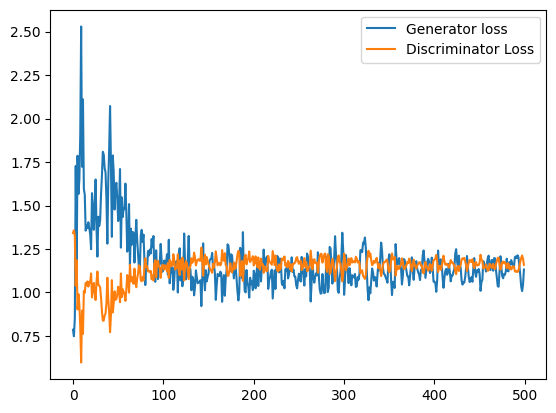

In [26]:
n_epoch = 500
D_losses_f, G_losses_f = [], []
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, x in tqdm(enumerate(train_loader)):
        # print(x.shape)
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (\
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    D_losses_f.append(torch.mean(torch.FloatTensor(D_losses)))
    G_losses_f.append(torch.mean(torch.FloatTensor(G_losses)))
plt.figure()
plt.plot(G_losses_f, label='Generator loss')
plt.plot(D_losses_f, label='Discriminator Loss')
plt.legend()
plt.show()

In [27]:
with torch.no_grad():
    for i in range(10):
        test_z = Variable(torch.randn(100, z_dim).to(device))
        g = G(test_z)
        mu, var = torch.split(g, 16, dim = 1)
        s = vae.sampling(mu, var)
        generated = vae.decoder(s)

        save_image(generated.view(generated.size(0), 1, 28, 28), f"ying/resultsm{i}.png")

In [28]:
torch.save(vae, 'vaeganmnist.pth')